# Tarea 2 - Procesamiento distribuido y redes neuronales profundas
**Integrantes:** 

Camila Goméz Nazal -
Ignacio Zurita Tapia

In [101]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.datasets import DatasetFolder
import torchvision.models as models
from torchvision.transforms import Compose, RandomHorizontalFlip, Resize, RandomRotation, Lambda, ToTensor, CenterCrop, Normalize, ToPILImage
from torch.utils.data import DataLoader, Sampler, RandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from IPython.display import HTML
from PIL import Image
from torchvision import get_image_backend
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from skimage.io import imshow
from sklearn.linear_model import LogisticRegression 
from keras.applications.imagenet_utils import decode_predictions
seed = 81818 
torch.random.manual_seed(seed)

## Carga y transformación de datos


#### 1. Dataset Folder

In [190]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
            
def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def loader(path):
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [191]:
scale = Lambda(lambda x: torch.div(x, torch.max(x)))
brightness = Lambda(lambda x: torch.mul(x, torch.FloatTensor(x.shape[0], x.shape[1], x.shape[2]).uniform_(1.2, 1.5)))

In [222]:
root = 'ChestXRay2017/chest_xray'
extensions = ('.jpeg')
transform = Compose([Resize([224,224]),
                     RandomHorizontalFlip(0.5),
                     RandomRotation([-20,20]),
                     ToTensor(),
                     brightness,
                     scale
                    ])

train = DatasetFolder(root + '/train', loader, extensions, transform)
test = DatasetFolder(root + '/test', loader, extensions, transform)

#### 2. Cantidad de muestras en cada clase en train y test:



In [5]:
HTML(filename='distribucion_datos.html')

,Normal,Neumonía
Train,1349,3884
Test,234,390


#### 3.

In [208]:
etiquetas_prueba = list(zip(*test.samples))[1]
l1=len(test.samples)
ind_test = np.random.choice(l1, l1 )
ind_test.shape

(624,)

In [209]:
l =len(train.samples)
np.random.seed(0)
indices = np.random.choice(l, l, replace=False)
indices.shape

(5232,)

In [210]:
ind_train = indices[:int(0.8*l)]
ind_val   = indices[int(0.8*l):]
print(ind_train.shape)
print(ind_val.shape)

(4185,)
(1047,)


In [211]:
val_samples = [train.samples[i] for i in ind_val]
etiquetas_val  = list(zip(*val_samples))[1]
print(etiquetas_val.count(0))
print(etiquetas_val.count(1))

263
784


In [212]:
class ReplicarMuestreoDePrueba(Sampler):
    def __init__(self, etiquetas_prueba, indices_val, etiquetas_val):
        self.etiquetas_prueba = etiquetas_prueba
        self.indices_val      = indices_val
        self.etiquetas_val    = etiquetas_val
    def __iter__(self):
        dist_test   = self.etiquetas_prueba.count(0)/self.etiquetas_prueba.count(1)
        dist_val    = int(self.etiquetas_val.count(1)*dist_test)
        nro_etiq_nuevas = dist_val - self.etiquetas_val.count(0) 
        c=0
        for i in range(len(etiquetas_val)):
            if etiquetas_val[i]==0:
                self.indices_val.append(self.indices_val[i])
                c+=1
            if c==nro_etiq_nuevas:
                break
        return iter(self.indices_val)

c = ReplicarMuestreoDePrueba(etiquetas_prueba,list(ind_val),etiquetas_val)
it = c.__iter__()

#### 4.

In [213]:
train_sampler = SubsetRandomSampler(ind_train)
valid_sampler = SubsetRandomSampler(list(it))
test_sampler = RandomSampler(ind_test)

batch_size = 16
train_loader = torch.utils.data.DataLoader(train, batch_size= batch_size, 
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train, batch_size= batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, 
                                           sampler=test_sampler)

print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

262
79
39


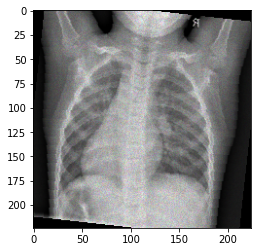

In [12]:
plt.imshow(train[0][0].permute(1, 2, 0).numpy())

## Redes convolucionales profundas

1.

In [102]:
class DWSepConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=True):
        super(DWSepConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=1,
                                   padding=padding, bias=bias, groups = in_channels)
        self.pointwise = nn.Conv2d(in_channels , out_channels, kernel_size=1)
    def forward(self,x):
        D = self.depthwise(x)
        P = self.pointwise(D)
        return P
        

2.

In [117]:
class VGG16DWSep(nn.Module):
    def __init__(self):
      super(VGG16DWSep, self).__init__()
      self.conv1 = nn.Conv2d(3, 64,kernel_size=3,stride=1,padding=1)
      self.relu = nn.ReLU()
      self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1)
      self.maxPool2d = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
      self.DW1 = DWSepConv2d(64,128,kernel_size=3, padding=1)
      self.DW2 = DWSepConv2d(128,128,kernel_size=3, padding=1)
      self.DW3 = DWSepConv2d(128,256,kernel_size=3, padding=1)
      self.batchNorm1 = nn.BatchNorm2d(256)
      self.DW4 = DWSepConv2d(256,256,kernel_size=3, padding=1)
      self.batchNorm2 = nn.BatchNorm2d(256)
      self.DW5 = DWSepConv2d(256,256,kernel_size=3, padding=1)
      self.DW6 = DWSepConv2d(256,512,kernel_size=3, padding=1)
      self.batchNorm3 = nn.BatchNorm2d(512)
      self.DW7 = DWSepConv2d(512,512,kernel_size=3, padding=1)
      self.flatten = nn.Flatten()
      self.linear1 = nn.Linear(100352, 1024)
      self.drop1 = nn.Dropout(p=0.7)
      self.linear2 = nn.Linear(1024,512)
      self.drop2 = nn.Dropout(p=0.5)
      self.linear3 = nn.Linear(512,2)
        
    def forward(self,x):
      y = self.conv1(x)
      y = self.relu(y)
      y = self.conv2(y)
      y = self.relu(y)
      y = self.maxPool2d(y)
      y = self.DW1(y)
      y = self.relu(y)
      y = self.DW2(y)
      y = self.relu(y)
      y = self.maxPool2d(y)
      y = self.DW3(y)
      y = self.relu(y)
      y = self.batchNorm1(y)
      y = self.DW4(y)
      y = self.relu(y)
      y = self.batchNorm2(y)
      y = self.DW5(y)
      y = self.relu(y)
      y = self.maxPool2d(y)
      y = self.DW6(y)
      y = self.relu(y)
      y = self.batchNorm3(y)
      y = self.DW7(y)
      y = self.relu(y)
      y = self.maxPool2d(y)
      y = self.flatten(y)
      y = self.linear1(y)
      y = self.relu(y)
      y = self.drop1(y)
      y = self.linear2(y)
      y = self.relu(y)
      y = self.drop2(y)
      y = self.linear3(y)
      return y
         

3.

In [113]:
vgg16 = models.vgg16(pretrained=True)
model = VGG16DWSep()

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

In [ ]:
model.conv1 = vgg16.features[0]
model.conv2 = vgg16.features[2]
model.conv1.weight.requires_grad = False
model.conv1.bias.requires_grad = False
model.conv2.weight.requires_grad = False
model.conv2.bias.requires_grad = False

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

4.

5.

## Interpretabilidad

1.

In [119]:
transform2 = Compose([Resize([299,299]),
                      CenterCrop(299),
                      ToTensor(),
                      Normalize(mean= [0.485, 0.456, 0.406] , std =[0.229, 0.224, 0.225])
                     ])

2.

In [6]:
inceptV3 = models.inception_v3(pretrained=True)

In [120]:
img= Image.open("C:/Users/camil/tarea2-MA6202/P3_example.jpg").convert('RGB') 
img = transform2(img)
img.shape

torch.Size([3, 299, 299])

In [121]:
inceptV3.eval()
with torch.no_grad():
    pred = inceptV3.forward(img.unsqueeze(0))

pred = decode_predictions(np.asarray(pred),top = 1)
pred[0][0][1]

'Labrador_retriever'

3.

torch.Size([3, 299, 299])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


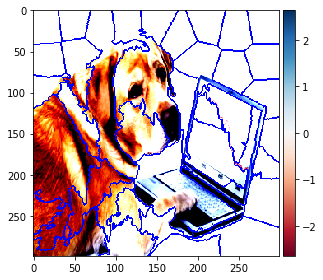

In [122]:
print(img.shape)
img_asnp = np.asarray(torch.rot90(img.T, -1))
img_seg = slic(img_asnp, n_segments=80)
mb = mark_boundaries(img_asnp, img_seg, color=[0,0,1])
imshow(mb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


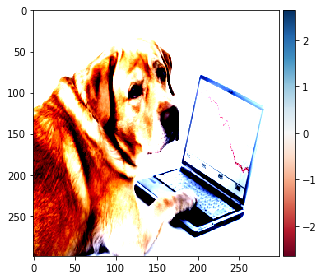

In [123]:
imshow(img_asnp)

In [124]:
a = np.unique(img_seg, return_counts=True)[0]
print(a)
len(a)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]


38

4.

In [125]:
perturb = []
for i in range(1000):
    perturb.append(np.random.binomial(1, 0.5, len(a)))
perturb[0].shape

(38,)

5.

In [126]:
imgs_per = []
for i in range(1000):
    pert=perturb[i]
    im = np.copy(img_asnp)
    for i in range(pert.shape[0]):
        if pert[i] == 0:
            mask = img_seg==a[i]
            im[mask] = 0
           
    imgs_per.append(im)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


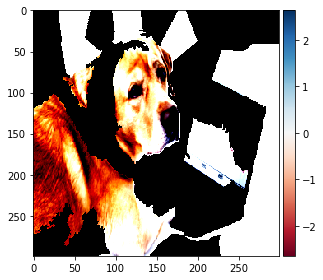

In [127]:
imshow(imgs_per[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


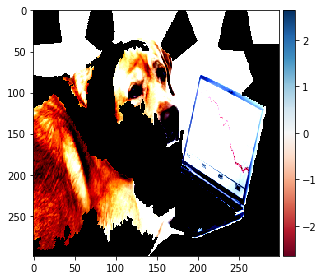

In [128]:
imshow(imgs_per[500])

6.

In [130]:
y=[]
inceptV3.eval()
with torch.no_grad():
    for i in range(1000):
        trans1 = ToTensor()
        img = trans1(imgs_per[i])
        pred1 = inceptV3.forward(img.unsqueeze(0))
        pred1 = decode_predictions(np.asarray(pred1),top = 1)
        if pred1[0][0][1] == pred[0][0][1]:
            y.append(1)
        else:
            y.append(0)

y.count(1)

518

7.

In [131]:
def d(x_p, z_p):
    v = x_p @ z_p
    v1 = np.linalg.norm(x_p) * np.linalg.norm(z_p)
    v2 = v/v1
    return 1 - v2

def pi_x(x_p, z_p, sigma):
    dist = - ( (d(x_p,z_p))**2 )
    val = dist / (sigma**2)
    return np.exp(val)

dist_coseno=[]
for i in range(len(perturb)):
    pi = pi_x(a,perturb[i], 0.2)
    dist_coseno.append(pi)

dist_coseno=np.array(dist_coseno)
dist_coseno.shape

(1000,)

8.

In [132]:
train_Dp = np.array(perturb)
labels = np.array(y)
print(train_Dp.shape)
print(labels.shape)

(1000, 38)
(1000,)


9.

In [133]:
model = LogisticRegression()
model.fit(train_Dp, labels, sample_weight = dist_coseno)

C:\Users\camil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

10.

In [134]:
coefs = model.coef_
coefs = coefs.reshape(len(a),1)

In [135]:
max(coefs)

array([1.72257286])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


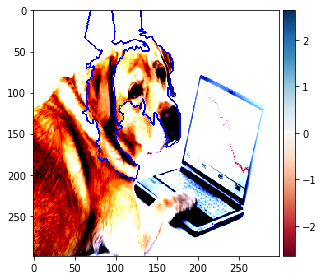

In [140]:
img_seg_importantes = np.copy(img_seg)
for i in range(len(a)):
    if coefs[i]< (max(coefs)/2):
        mask = img_seg_importantes==a[i]
        img_seg_importantes[mask] = -1
    
mb = mark_boundaries(img_asnp, img_seg_importantes, color = [0,0,1])
imshow(mb)

11.

In [141]:
from skimage.color import rgb2gray

img_gray = rgb2gray(img_asnp)

In [142]:
img_gray.shape

(299, 299)

In [143]:
observaciones = []
for i in range(299):
    for j in range(299):
        arr = np.zeros(3)
        arr[0] = i
        arr[1] = j
        arr[2] = img_gray[i][j]
        observaciones.append(arr)

observaciones = np.asarray(observaciones)
observaciones.shape

(89401, 3)

In [144]:
observaciones

array([[  0.        ,   0.        ,   2.37968183],
       [  0.        ,   1.        ,   2.37968183],
       [  0.        ,   2.        ,   2.37968183],
       ...,
       [298.        , 296.        ,   2.40563703],
       [298.        , 297.        ,   2.40563703],
       [298.        , 298.        ,   2.40563703]])

In [145]:
from sklearn.cluster import KMeans

est = KMeans(n_clusters=len(a))
X = observaciones
clust_list = est.fit_predict(X)



In [146]:
clust_list = clust_list.reshape(299,299)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


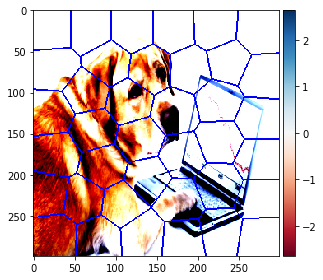

In [147]:
mb = mark_boundaries(img_asnp, clust_list, color=[0,0,1])
imshow(mb)

12.

In [30]:
clust_list

array([[11, 11, 11, ...,  8,  8,  8],
       [11, 11, 11, ...,  8,  8,  8],
       [11, 11, 11, ...,  8,  8,  8],
       ...,
       [26, 26, 26, ...,  7,  7,  7],
       [26, 26, 26, ...,  7,  7,  7],
       [26, 26, 26, ...,  7,  7,  7]])

In [170]:
a = np.unique(clust_list)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [173]:
perturb = []
for i in range(1000):
    perturb.append(np.random.binomial(1, 0.5, len(a)))

imgs_per = []
for i in range(1000):
    pert=perturb[i]
    im = np.copy(img_asnp)
    for i in range(pert.shape[0]):
        if pert[i] == 0:
            mask = clust_list==a[i]
            im[mask] = 0
           
    imgs_per.append(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


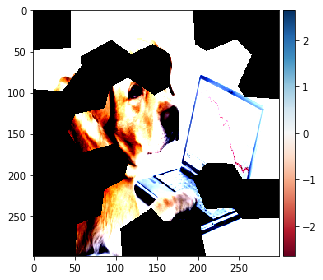

In [174]:
imshow(imgs_per[0])

In [175]:
y=[]
inceptV3.eval()
with torch.no_grad():
    for i in range(1000):
        trans1 = ToTensor()
        img = trans1(imgs_per[i])
        pred1 = inceptV3.forward(img.unsqueeze(0))
        pred1 = decode_predictions(np.asarray(pred1),top = 1)
        if pred1[0][0][1] == pred[0][0][1]:
            y.append(1)
        else:
            y.append(0)

y.count(1)

170

In [176]:
dist_coseno=[]
for i in range(len(perturb)):
    pi = pi_x(a,perturb[i], 0.2)
    dist_coseno.append(pi)

dist_coseno=np.array(dist_coseno)
dist_coseno.shape

(1000,)

In [177]:
train_Dp = np.array(perturb)
labels = np.array(y)
print(train_Dp.shape)
print(labels.shape)
model = LogisticRegression()
model.fit(train_Dp, labels, sample_weight = dist_coseno)

(1000, 38)
(1000,)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [178]:
max(coefs)

array([0.08840667])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


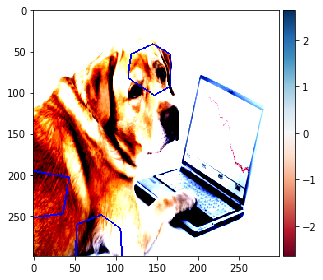

In [184]:
coefs = model.coef_
coefs = coefs.reshape(len(a),1)

img_seg_importantes = np.copy(clust_list)
for i in range(len(a)):
    if coefs[i]<(max(coefs)/2):
        mask = img_seg_importantes==a[i]
        img_seg_importantes[mask] = -1
    
mb = mark_boundaries(img_asnp, img_seg_importantes, color=[0,0,1])
imshow(mb)

13.

In [188]:
model = VGG16DWSep()
model.conv1 = vgg16.features[0]
model.conv2 = vgg16.features[2]
model.conv1.weight.requires_grad = False
model.conv1.bias.requires_grad = False
model.conv2.weight.requires_grad = False
model.conv2.bias.requires_grad = False

In [189]:
PATH = 'C:/Users/camil/Downloads/model.pt'
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [223]:
transform

Compose(
    Resize(size=[224, 224], interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-20, 20], resample=False, expand=False)
    ToTensor()
    Lambda()
    Lambda()
)

In [224]:
img= Image.open("C:/Users/camil/tarea2-MA6202/ChestXRay2017/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg").convert('RGB') 
img = transform(img)
img.shape

torch.Size([3, 224, 224])

In [226]:
model.eval()
with torch.no_grad():
      y_pred = model.forward(img.unsqueeze(0))
        

In [227]:
y_pred

tensor([[-26.4777,  29.7031]])

In [239]:
from scipy.special import softmax
pred = int(torch.max(softmax(y_pred)))

In [240]:
pred

1

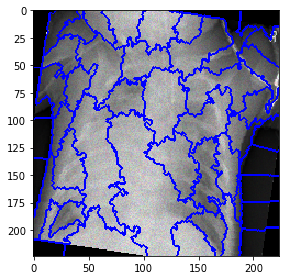

In [228]:
img_asnp = np.asarray(torch.rot90(img.T, -1))
img_seg = slic(img_asnp, n_segments=80)
mb = mark_boundaries(img_asnp, img_seg, color=[0,0,1])
imshow(mb)

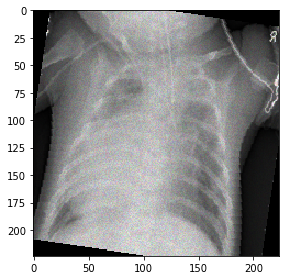

In [230]:
imshow(img_asnp)

In [229]:
a = np.unique(img_seg, return_counts=True)[0]
print(a)
len(a)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


46

In [231]:
perturb = []
for i in range(1000):
    perturb.append(np.random.binomial(1, 0.5, len(a)))
perturb[0].shape

(46,)

In [232]:
imgs_per = []
for i in range(1000):
    pert=perturb[i]
    im = np.copy(img_asnp)
    for i in range(pert.shape[0]):
        if pert[i] == 0:
            mask = img_seg==a[i]
            im[mask] = 0
           
    imgs_per.append(im)

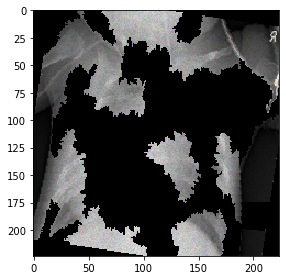

In [233]:
imshow(imgs_per[0])

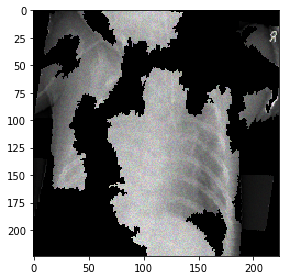

In [253]:
imshow(imgs_per[10])

In [241]:
y=[]
model.eval()
with torch.no_grad():
    for i in range(1000):
        trans1 = ToTensor()
        img = trans1(imgs_per[i])
        pred1 = model.forward(img.unsqueeze(0))
        pred1 = int(torch.max(softmax(pred1)))
        if pred1==1:
            y.append(1)
        else:
            y.append(0)

y.count(1)

993

In [242]:
dist_coseno=[]
for i in range(len(perturb)):
    pi = pi_x(a,perturb[i], 0.2)
    dist_coseno.append(pi)

dist_coseno=np.array(dist_coseno)
dist_coseno.shape

(1000,)

In [243]:
train_Dp = np.array(perturb)
labels = np.array(y)
print(train_Dp.shape)
print(labels.shape)
model = LogisticRegression()
model.fit(train_Dp, labels, sample_weight = dist_coseno)

(1000, 46)
(1000,)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [248]:
max(coefs)

array([0.25943478])

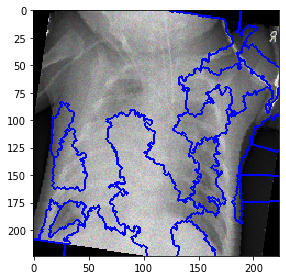

In [252]:
coefs = model.coef_
coefs = coefs.reshape(len(a),1)

img_seg_importantes = np.copy(img_seg)
for i in range(len(a)):
    if coefs[i]<(max(coefs)/1.4):
        mask = img_seg_importantes==a[i]
        img_seg_importantes[mask] = -1
    
mb = mark_boundaries(img_asnp, img_seg_importantes, color=[0,0,1])
imshow(mb)